In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import matplotlib.ticker as mticker

## Defining Constants

In [2]:
### Here we define constants from the QMC model - For the Sigma Baryon

w1   = 0.5847     ### Fitting constant for sigma meson (unitless)
w2   = 0.6629     ### Fitting constant for sigma meson (unitless)
wom  = 2/3        ### Fitting constant for omega meson (unitless)
d    = 0.176      ### Fitting constant for effective mass in [fm]
MeV  = 197.3      ### Conversion for [fm^-1] -> [MeV]
MSig = 1195       ### Mass of Sigma baryon in [MeV]
msig = 504        ### Mass of sigma Meson [MeV]

### Defining Coupling Constant
Gsig = 8.65                     ### Coupling constant from best fit
gsig = msig*np.sqrt(Gsig)/MeV   ### Defining the unitless coupling to the sigma field
Ssig = 1/(2*1.04)               ### Defining the factor linking the coupling factor to the sigma field
gsigq = gsig/(3*Ssig)           ### Defining the quark coupling

### Here we define constants for the Nuclear Potential, from 

a    = 0.322        ### Parameter for the Nuclear Potential (unitless)
w    = 1.74         ### Parameter for the Nuclear Potential (unitless)
c    = 0.964        ### Parameter for the Nuclear Potential in [fm]
rho0 = 0.15        ### Nuclear matter density in [fm^-3]

7.512967409635865
0.4807692307692307
5.208990737347534


### Defining Potentials and Nuclear Density

We first wish to normalise the nucleon density such that: $\int d^3r \rho(r) = 4$, as here were are working with Helium.

In addition, here we use the form for the nucleon density:

$$ \rho(r) = \frac{\rho_0(1+wr^2/c^2)}{1+exp((r-c)/a)} $$

In [5]:
### Defining the Nuclear Density

def rho(r):
    val = rho0*(1+w*r**2/c**2)/(1+np.exp((r-c)/a))
    return val


### Function included to calculate the correct normalisation
def rhonormalise(r):
    ### Here we include the r^2 term from the volume element of the integral. 
    val = rho0*r**2*(1+w*r**2/c**2)/(1+np.exp((r-c)/a))
    return val

### We now integrate over the integrand to obtain the normalisation
intval  = integrate.quad(rhonormalise, 0, 100)[0]
normrho = 4/(4*np.pi*intval)

### Redefining rho(r), now with the proper normalisation
def rho(r):
    val = normrho*rho0*(1+w*r**2/c**2)/(1+np.exp((r-c)/a))
    return val

In [18]:
### Defining the many-body potential
def V(r, Gsig, Gom, l):
    ### Coefficients for the many-body forces, in MeV
    c1   = -w1*Gsig*MeV + wom*Gom*MeV           ### 2-Body Forces
    c2   =  (d*w2/2+d*w1)*Gsig**2*MeV           ### 3-Body Forces
    
    ### Definining a term that accounts for the velocity-dependent terms from the equations of motion
    Inverse = 1#+Gsig*rho(r)*w1/MSig-Gsig**2*rho(r)**2*d*(w1-w2)/MSig
    
    ### Defining the Angular Momentum term
    if l==0:
        Ang = 0
    else:
        Ang  =  l*(l+1)/(2*MSig*r**2)*MeV**2
    
    ### Returning the Binding Potential
    result = (c1*rho(r)+c2*rho(r)**2)/(Inverse)+Ang
    
    return result

#### Second form for the Potential

The velocity dependent term also modifies the energy eigenvalue, and thus I had to include a second function for inputting into the Numerov Algorithm which accounts for this. We have here:
$\frac{(E-V(r))}{\text{Velocity-dependent terms}}$

And we note that from rearranging the Hamiltonian from the EoM that the angular momentum term is unaffected by the velocity-dependence, so we simply add it to the other term involved.

In [19]:
### Defining 2nd form for Potential which includes the energy term
def VTwo(r, E, Gsig, Gom,l):
    c1   = -w1*Gsig*MeV + wom*Gom*MeV            ### 2-Body Forces
    c2   =  (d*w2/2+d*w1)*Gsig**2*MeV            ### 3-Body Forces
    
    Inverse = 1+(Gsig*rho(r)*w1/MSig-Gsig**2*rho(r)**2*d*(w1-w2)/MSig)

    if l==0:
        Ang = 0
    else:
        Ang  =  l*(l+1)/(2*MSig*r**2)*MeV**2
    
    result = ((E-(c1*rho(r)+c2*rho(r)**2)/Inverse)+Ang)
    
    return result   

#### Defining Classical Turning Point Function

Now we will define some functions which will help to find solutions. We have one function which finds the classical turning point, which is the point where $E-V(r)$, changes sign. When solving using the numerov algorithm we will solve from either side, and match the solutions at the matchpoint which will be this classical turning point.

In [20]:
### Function to find the classical turning point of the potential

def ClassicalTurningPoint(x, N, E, Gsig, Gom, l):
    imatch=0
    VVec = VTwo(x, E, Gsig, Gom, l)  ### Creating a vector with the values for the potential
    
    ### Looping through the potential looking to find a turning point
    for j in range(N-1):
        CheckPoint = VVec[j]*VVec[j+1]
        if CheckPoint<=0  and VVec[j] > 0:  #match point
            imatch = j+1
    return imatch

# Implementing The Numerov Algorithm

The numerov algorithm is used to solve equations of the form: $\frac{d^2 y}{dx^2} = f(x)y(x)$.

When applying this to solve the schrodinger in this situation, the equation we have is in the form:
$\frac{d^2\psi}{dr^2} = -2M_\Lambda \left[ \frac{1}{\eta(r)}[E-V_{binding}(r)] -\frac{l(l+1)}{2M_\Lambda r^2}\right]\psi(r)$, which is in the form $\frac{d^2\psi}{dr^2} = f(r)y(r)$.

Where here, $\eta(r)$ is the velocity dependent term, which has the form: $\eta(r) = \left[1+\frac{1}{M_\Lambda}G_\sigma w \rho_N-\frac{1}{M_\Lambda}\left(w+\frac{\tilde{w}}{2}\right)dG_\sigma^2\rho_N^2+\frac{1}{M_\Lambda}\left(w+\tilde{w} \right)d^2G_\sigma^3\rho^3_N\right]$.

$V_{binding}(r)$ is the binding potential, which has the form: $V_{binding}(r)=-G_\sigma w \rho_N(r)+w_\omega G_\omega\rho_N(r)+\left(w+\frac{\tilde{w}}{2}\right)dG_\sigma^2 \rho_N^2(r)-\left(w +\tilde{w}\right)d^2G_\sigma^3\rho^3_N(r)$.

And the final term is the term containing the angular momentum dependence.
We note then that calling the function VTwo in the code is calling $f(r)$, as in the algorithm above, up to a factor of $2M_\Lambda$, which is included in the numerov solver below.

In [21]:
### Code to find the solution from the left of the matchpoint

def NumerovLeft(x, psi0, psi1, E, h, Gsig, Gom, l, imatch):
    
    ### Defining a vector with all the values for the potential for a given test solution
    VVec = VTwo(x, E, Gsig, Gom, l)
    
    ### The term including the step size in the numerov algorithm
    ### Not for our solution here this term includes the mass of the Lambda
    mh12 = MSig*h**2/(6*MeV**2)
    
    ### Initialising a vector of zeros with the length of the left-side solution
    PsiL = np.zeros(imatch)
    
    ### Inputting the inital conditions for the solution
    PsiL[0] = psi0
    PsiL[1] = psi1
    
    ### Iterating to find the left-side solution
    for i in range(2, imatch):
        w2 = 1+mh12*(VVec[i])
        w1 = 2*(1-(5*mh12)*(VVec[i-1]))*PsiL[i-1]
        w0 = (1+mh12*(VVec[i-2]))*PsiL[i-2]
        
        ### Filling out the vector with all the calculated values from the numerov algorithm
        PsiL[i] = (w1-w0)/w2
    
    
    return PsiL


### Code to find the solution for the right side of the matchpoint

def NumerovRight(x, psiN, psiNm1, E, h, Gsig, Gom, l, imatch):
    
    ### Defining a vector with all the values for the potential for a given test solution
    VVec = VTwo(x, E, Gsig, Gom, l)
    
    ### The term including the step size in the numerov algorithm
    ### Not for our solution here this term includes the mass of the Lambda
    mh12 = MSig*h**2/(6*MeV**2)
    
    ### Defining the length of the right-side solution
    dim = N-imatch
    
    ### Initialising a vector of zeros with the length of the right-side solution
    PsiR    = np.zeros(dim)
    
    ### Inputting the initial conditions for the right-side solution
    PsiR[0] = psiN
    PsiR[1] = psiNm1
    
    ### Iterating to find the solutions for the right-side
    for i in range(2, dim):
        w2 = 1+mh12*(VVec[i])
        w1 = 2*(1-(5*mh12)*(VVec[i-1]))*PsiR[i-1]
        w0 = (1+mh12*(VVec[i-2]))*PsiR[i-2]
        
        ### Filling out the vector with all the calculated values from the numerov algorithm
        PsiR[i] = (w1-w0)/w2
    
    ### We have at this stage the solution back to front for a right-side solution.
    ### This is because of the way we arranged the loop
    ### So we now flip the solution around to find the right-side solution properly
    PsiR = np.flip(PsiR)
    
    return PsiR

## Defining a Function to find Energy Eigenstate

We now have functions to calculate the wavefunction for a given energy, so we now need to put this together to find a valid energy eigenstate. This process works by:

1. Take in the energy that is trying to be fit to.

2. Solve for the wavefunction for the given energy using the numerov algorithm. We solve the equation by finding the classical energy turning point, and integrating from the left to the match point, and indenpendently from the right to the match point. This allows for us to test whether the energy is a valid energy eigenstate, and also helps to minimise numerical errors.

3. We then enforce continuity by scaling the left side solution to match that at the right side

4. After normalising the wavefunction we can test for smoothness. If the wavefunction is smooth we have found a valid energy eigenstate, and return Echeck as true. If it is not then we return Echeck as false. We also return the wavefunction Psi.

In [22]:
def Find_Energy(x, E, dE, Gsig, Gom, l, psi0, psi1, psiNm1, psiN, eps):
    
    ### We begin by initialising a number of constants. 
    Psi   = np.zeros(N)      ### Initialising a vector of zeros for our solution
    check = 0                ### Defining a counter to let us find the upper and lower bounds for the energy.
    Eerr  = 0                ### Defining the error in the energy
    dE    = np.abs(dE)       ### Ensuring the step size for the energy is positive
    
    ### We begin iterating over energy values until we find a valid solution
    

    ### We first find the solutions to the Schrodinger equation for a given energy
    ### This is done using the above numerov algorithm.
    matchP = ClassicalTurningPoint(x, N, E, Gsig, Gom, l)
    PsiL = NumerovLeft(x, psi0, psi1, E, h, Gsig, Gom, l, matchP)
    PsiR = NumerovRight(x, psiN, psiNm1, E, h, Gsig, Gom, l, matchP)
        
        
    ### Now we wish for our solution to be continuous
    ### We can enforce this by scaling one side of the solution by the other
    PsiLmatch = PsiL[matchP-1]
    PsiRmatch = PsiR[0]
    scale     = PsiRmatch/PsiLmatch
    PsiL      = scale*PsiL
        
        
    ### Following this we shall combine the left and right side solutions to one solution and then normalise it
    Psi     = np.concatenate((PsiL, PsiR), axis=None)
        
    ### A simpson integration routine is used to find the normalisation (NO FACTOR OF x^2, as we return r\psi from routine)
    Norm    = integrate.simpson(4*np.pi*Psi*Psi, x)
    PsiNorm = Psi/np.sqrt(Norm)
        
    ### To determine if the solution is valid we test for the smoothness of the functions.
        
    PsiLmm1 = PsiL[matchP-2]
    PsiRmp1 = PsiR[1]
        
    ### Defining an approximatin for the first derivative
    diff = np.abs(PsiLmm1+PsiRmp1-2*PsiRmatch)/(np.sqrt(Norm)*h)
        
    ### I've removed a lot of the code to do with finding the mean below, as it is not necessary to solve this 
    ### particular problem
        
    ### Checking whether the generated solution is a valid solution
    if diff<eps:
        Echeck = True
        
    ### If the solution is not accepted iterate to the next energy 
    ### (note this amounts to setting E = Efit+dE so in the BindFit function the if statement is not true).
    else:
        Echeck = False
        
    return PsiNorm, Echeck

## Function to fit Binding Energy

From here we wish to adjust the $G_\omega$ coupling constant to fit the $\Sigma^0$ binding energy. To find the fit we:

1. Take as an input the energy we wish to fit for, for a given value of $G_\sigma$, and a vector of $G_\omega$ values to test over, along with the angular momentum state.

2. We then proceed to call the Find_Energy function for each value of $G_\omega$ until a valid solution is found.

3. When a valid solution is found we return the value for $G_\omega$ and the corresponding wavefunction.

In [23]:
### Here we have code to fit the binding energy of the Sigma^0 by varying G_\omega

def BindFit(x, Efit, dE, Gsig, GomVec, l, psi0, psi1, psiNm1, psiN, eps):
    ### Defining the value to loop over based on the size of the values to be tested
    TestRange = np.size(GomVec)
    
    ### Looping over values of G_\omega to find one which fits the desired binding energy
    for i in range (TestRange):
        ### Calling a function to find if the binding energy is a valid solution for the given G_\omega
        Psi, Echeck = Find_Energy(x, Efit, dE, Gsig, GomVec[i], l, psi0, psi1, psiNm1, psiN, eps)
        
        ### If the solution is a valid solution, then the wavefunction and coupling constant for 
        ### G_\omega are returned. Otherwise the loop continues until a valid solution is found.
        if Echeck == True:
            Gom = GomVec[i]
            break
    return Psi, Gom

## Defining the Constants used in the Solutions

In [24]:
### Defining the grid spacing

N = 20000                      ### Number of points used
L = 20                        ### Distance to integrate out to
h = L/N                       ### Grid spacing
x = np.linspace(1e-3, L, N)   ### Vector filled with points for distance

### Defining Function Parameters for Numerov Algorithm

dE    = 0.0001       ### Energy stepsize
eps   = 1e-4         ### Error tolerance for whether a solution has been found
maxit = 10000        ### Number of iterations for energy values that would be carried out

### Boundary Conditions

psi0   = 0
psi1   = 0.1
psiN   = 0.001
psiNm1 = 0.005

### Defining the physical values taken as an input to the function

Gsig     =  8.65                     ### Setting the coupling constant for Gsigma as that from the best fit for Lambda hyperpons
GomVec   =  np.linspace(0, 6, 6001)  ### Testing over a wide range of Gomega values
EBinding = -7.6                      ### The binding energy for Sigma^0 hyperons in ^4 He
l        =  0                        ### Testing for angular momentum state 0

GsigVec  = np.linspace(8.65, 10.6, 195)
GsigVec  = np.flip(GsigVec)

In [25]:
### Calling the fitting function to obtain the wavefunction
Psi, Gom = BindFit(x, EBinding, dE, Gsig, GomVec, l, psi0, psi1, psiNm1, psiN, eps)
print('The fit for the Omega Coupling is:', Gom)

The best for the Omega Coupling is: 3.54


Text(0.5, 1.0, '$\\Sigma^0$ Wavefunction')

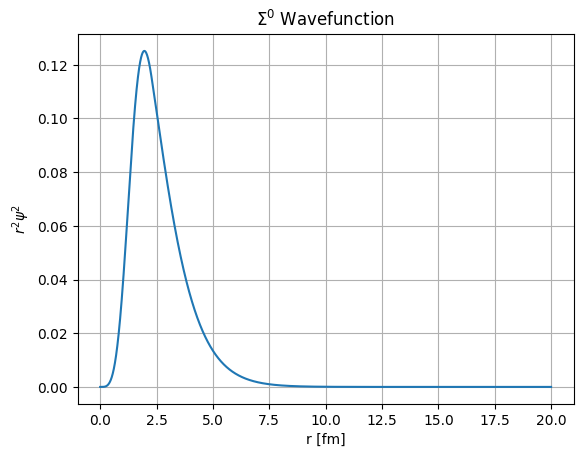

In [14]:
plt.plot(x, x**2*Psi**2)
plt.grid()
plt.xlabel('r [fm]')
plt.ylabel(r'$r^2 \psi^2$')
plt.title(r'$\Sigma^0$ Wavefunction')

## Calculating Mean-Values

We now turn to calculating $<g_\sigma^q \sigma>$ and $<\rho>$. To do this we calculate the integrals:

$<g_\sigma^q \sigma> = \int dV \bar{\psi} g_\sigma^q \sigma \psi$ and $<\rho> = \int dV \bar{\psi} \rho \psi$

So we first define the integrands and then perform a simpson integration routine. 

Here $\rho$ is as defined earlier, and the equation for $<g_\sigma^q \sigma>$ comes from the equations of motion, and is given by:
$<g_\sigma^q \sigma> = G_\sigma\rho(r)[1-dG_\sigma \rho(r)]/(3S(\sigma=0))$, as $g_\sigma^q =  g_{\sigma N}/3S(\sigma=0)$

In [27]:
def gsigSigma(r):
    ### Defining a function to call gsig^q \sigma in MeV
    sig = Gsig*rho(r)*(1-d*Gsig*rho(r))*MeV
    return sig 

### Defining functions to call the integrand to be called for the numerical integrations
def MeanSigmaIntegrand(r, Psi):
    Int = 4*np.pi*Psi*gsigSigma(r)*Psi
    return Int

def MeanDensIntegrand(r, Psi):
    ### Using the definition for \rho from above.
    Int = 4*np.pi*Psi*rho(r)*Psi
    return Int

### Performing the Numerical Integration, with respect to x. x has the same spacing as Psi here,
### so this will ensure the correct value for the numerical integration.
SigBar = integrate.simps(MeanSigmaIntegrand(x, Psi), x)

rhoBar = integrate.simps(MeanDensIntegrand(x, Psi), x)

### Returning the Results of the Integration

print('The mean value of the field, with the quark coupling is:', gsigq/gsig*SigBar, '[MeV]')

print('The mean value of the nuclear density is:', rhoBar, '[fm^-3]')

50.411663179738326
The mean value of the field, with the quark coupling is:, 71.20178197922684 [MeV]
The mean value of the nuclear density is: 0.07217730775030472 [fm^-3]
